***Method***

- Implementing a Transformer-based Seq2Seq architecture, my model diverges from the original Transformer approach by incorporating a Recurrent Neural Network (RNN) for processing both input and output. The SMILES string's individual characters are initially mapped to integers, passed to an Embedding layer to elevate them to a higher dimension before input to the Encoder.

- Encoder: The input is passed through a Self-Attention layer, enabling the model to learn relationships between atoms and bonds within the SMILES structure. The output attention is then concatenated with the original input and directed to an LSTM layer. The LSTM sequentially processes the input, producing hidden states at each time step, and a final state which contain all the necessary information. All hidden states and final state are input to the Decoder.

- Decoder: The last hidden state from the Encoder serves as the first hidden state of the Decoder, functioning as the Query. Employing a Cross-Attention layer (Bahdanau Attention) to let Decoder strategically focuses on correct hidden states from the Encoder for each steps. The acquired attention is concatenated with previous Decoder time steps to predict the subsequent output.

In [56]:
DIM_MODEL = 128
NUM_BLOCK = 1
NUM_HEAD = 4
DROPOUT = 0.5
FE = 1

BATCH_SIZE = 16
NUM_EPOCHS = 50
TEACHER_FORCING_RATE = 0.0
LEARNING_RATE = 0.001
PATIENCE_THRESHOLD = 4
ATTENTION_IMAGE_OUTPUT_PATH = 'image'

SMILES_PATH = '../data/ADAGRASIB_SMILES.txt'
COORDINATE_PATH = '../data/ADAGRASIB_COOR.sdf'

In [57]:
import rdkit
import pandas as pd
import numpy as np 
import time
import math
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_all_atom(smi_path) :
    smi_dic = {}
    i = 0

    with open(smi_path, 'r') as file :
        for smi in file :
            smi = rdkit.Chem.MolFromSmiles(smi)
            for atom in smi.GetAtoms() :
                atom = atom.GetSymbol()
                if atom not in smi_dic : 
                    smi_dic[atom] = i 
                    i += 1
    return smi_dic

def replace_atom(input, mode = 'train') :
    if mode == 'train' :
        smi_list = [smi.replace('Cl', 'X')
                    .replace('Br', 'Y')
                    .replace('Na', 'Z')
                    .replace('Ba', 'T') for smi in input]
        return smi_list
        
    if mode == 'eval' :
        smi = input.replace('X', 'Cl').replace('Y', 'Br').replace('Z', 'Na').replace('T', 'Ba').replace('x','')
        return smi

def get_longest(input_list) :
    longest = 0
    for i in input_list :
        if len(i) > longest :
            longest = len(i)
    return longest

def get_coor(coor_path) :
    coor_list = []
    supplier = rdkit.Chem.SDMolSupplier(coor_path)
    for mol in supplier:
        coor = []
        if mol is not None:
            conformer = mol.GetConformer()
            for atom in mol.GetAtoms():
                atom_idx = atom.GetIdx()
                x, y, z = conformer.GetAtomPosition(atom_idx)
                coor_atom = list((x,y,z))
                coor.append(coor_atom)
        coor_list.append(coor)

    # Replace invalid idx
    for i, coor in enumerate(coor_list):
        
        if len(coor) == 0 :
            if i == 0 :
                coor_list = coor_list[1:]
            coor_list[i] = coor_list[i-1]
    return coor_list

def get_smi(smi_path) :
    smi_list = []
    i = 0
    with open(smi_path, 'r') as file :
        for smi in file :
            if rdkit.Chem.MolFromSmiles(smi) is None :
                if len(smi_list) == 0 :
                    continue 
                smi_list.append(smi_list[i-1])
                i += 1 
                continue 
            smi_list.append(smi)
            i += 1
    
    smi_list = [smi[:-1] for smi in smi_list]
    smi_list = [smi + 'E' for smi in smi_list]
    smi_list = replace_atom(smi_list)
    return smi_list

def get_dic(smi_list) :
    smi_dic = {'x': 0,
               'E': 1}
    i = len(smi_dic)

    for smi in smi_list : 
        for atom in smi :
            if atom not in smi_dic : 
                smi_dic[atom] = i
                i += 1 
    return smi_dic 

def count_atoms(smi):
    mol = rdkit.Chem.MolFromSmiles(smi)
    if mol is not None:
        num_atoms = mol.GetNumAtoms()
        return num_atoms
    else:
        print("Error: Unable to parse SMILES string.")
        return None
    
def smi2int(smi, smi_dic, longest_smi, mode = 'data') :
    if mode == 'eval' :
        # smi += 'E'
        smi = smi + 'E' if smi[-1] != 'E' else smi
        smi = list(smi)
        smint = [smi_dic[atom] for atom in smi]
        smint = smint + [0] * (longest_smi - len(smint))
        smint = torch.tensor(smint, dtype=torch.long, device = device)
        smint = smint.unsqueeze(0)
        return smint
    smi = list(smi)
    smint = [smi_dic[atom] for atom in smi]
    smint = smint + [0] * (longest_smi - len(smint))
    return smint 

def int2smi(smint, inv_smi_dic) :
    smint = smint.cpu().numpy()
    
    smi = [inv_smi_dic[i] for i in smint] 
    smi = ''.join(smi)
    smi = replace_atom(smi, mode = 'eval')
    return smi


def normalize_coor(coor_list) :
    n_coor_list = []

    for mol_coor in coor_list :
        n_mol_coor = []

        x_origin, y_origin, z_origin = mol_coor[0]

        for atom_coor in mol_coor :
            n_atom_coor = [round(atom_coor[0] - x_origin, 2), 
                        round(atom_coor[1] - y_origin, 2), 
                        round(atom_coor[2] - z_origin, 2)]
            n_mol_coor.append(n_atom_coor)
        n_coor_list.append(n_mol_coor)
    return n_coor_list

def pad_coor(coor_list, longest_coor) :
    p_coor_list = []

    for i in coor_list :
        if len(i) < longest_coor :
            zeros = [[0,0,0]] * (longest_coor - len(i))
            zeros = torch.tensor(zeros)
            i = torch.tensor(i)
            i = torch.cat((i, zeros), dim = 0)
            p_coor_list.append(i)
        else :
            p_coor_list.append(i)
    return p_coor_list

def split_data(input, ratio = [0.9,0.05,0.05]) :
    assert sum(ratio) == 1, "Ratio does not add up to 1"  
    stop1 = int(len(input) * ratio[0])
    stop2 = int(len(input) * (ratio[0] + ratio[1])) 

    train = input[:stop1]
    val = input[stop1:stop2]
    test = input[stop2:]

    return train, val, test
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def evaluate(input, encoder, decoder, smi_dic, longest_smi) :
    encoder.eval(), decoder.eval()
    if type(input) == str :
        input = smi2int(input, smi_dic, longest_smi, mode = 'eval')
    
    with torch.no_grad() :
        e_all, e_last, self_attn = encoder(input) 
        prediction, cross_attn = decoder(e_all, e_last)

        prediction, self_attn, cross_attn = prediction.squeeze(0), self_attn.squeeze(0), cross_attn.squeeze(0)
    return prediction, self_attn, cross_attn


def plot_attn(matrix, smi, mode, output_path = "", output_name = "", output_type = "show") :

    if mode == "cross" :
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(matrix, cmap = "viridis")
        fig.colorbar(cax)
        ax.set_xticklabels([''] + list(smi))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


    if mode == "self" :
        num_head = matrix.shape[0]
        
        fig, ax = plt.subplots(1, num_head, figsize=(num_head*10,30))
        for i, head in enumerate(matrix) :
            cax = ax[i].matshow(head, cmap='viridis')
            # fig.colorbar(cax)
            ax[i].set_xticklabels([''] + list(smi), fontsize="xx-large")
            ax[i].set_yticklabels([''] + list(smi), fontsize='xx-large')
            
            ax[i].xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax[i].yaxis.set_major_locator(ticker.MultipleLocator(1))
    if output_type == "show" :
        plt.show()
    if output_type == "save" :
        plt.savefig(f"{output_path}/{output_name}")
    plt.close()
    
def visualize(smi,
              encoder, decoder,
              smi_dic, longest_smi,
              output_path = ATTENTION_IMAGE_OUTPUT_PATH,
              output_name="test",
              output_type="show") :
    
    
    prediction, self_attn, cross_attn = evaluate(smi, encoder, decoder, smi_dic, longest_smi)

    
    self_attn = self_attn.cpu().numpy()
    cross_attn = cross_attn.cpu().numpy()

    smi = smi[:-1] if smi[-1] == 'E' else smi
    # smi = replace_atom(smi, mode='eval')

    coor_len = count_atoms(smi)
    smi_len = len(smi) 

    plot_attn(self_attn[:, :smi_len, :smi_len],smi=smi, mode='self', output_path=output_path, output_name=f"{output_name}-SELF", output_type=output_type)
    plot_attn(cross_attn[:coor_len, :smi_len],smi=smi, mode='cross', output_path=output_path, output_name=f"{output_name}-CROSS", output_type=output_type)


In [59]:
smi_list = get_smi(SMILES_PATH)
longest_smi = get_longest(smi_list)
smi_dic = get_dic(smi_list)
inv_smi_dic = {value:key for key, value in smi_dic.items()}
smint_list = [smi2int(smi, smi_dic, longest_smi) for smi in smi_list]


coor_list = get_coor(COORDINATE_PATH)
longest_coor = get_longest(coor_list)
np_coor_list = pad_coor(normalize_coor(coor_list), longest_coor)
count_list = [count_atoms(replace_atom(smi, 'eval')[:-1]) for smi in smi_list]

train_count, val_count, test_count = split_data(count_list)
train_smint, val_smint, test_smint = split_data(smint_list)
train_coor, val_coor, test_coor = split_data(np_coor_list)


In [60]:
class ADAGRASIB_Dataset(Dataset) :
    def __init__(self, smint_list, coor_list, count_list) :
        self.smint_list = torch.tensor(smint_list, dtype = torch.long, device=device)
        self.coor_list = [torch.round(torch.tensor(coor, device=device), decimals=2) for coor in coor_list]
        self.count_list = count_list
    def __len__(self) :
        return len(self.smint_list)
    
    def __getitem__(self, idx) :
        return self.smint_list[idx], self.coor_list[idx], self.count_list[idx]
    
train_set = ADAGRASIB_Dataset(train_smint, train_coor, train_count)
val_set = ADAGRASIB_Dataset(val_smint, val_coor, val_count)
test_set = ADAGRASIB_Dataset(test_smint, test_coor, test_count)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_3984\1815108439.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.coor_list = [torch.round(torch.tensor(coor, device=device), decimals=2) for coor in coor_list]


In [61]:
# for smint, coor, count in val_loader :
#     print(count)
#     break

In [62]:
class NN_Attention(nn.Module): # Neural Network Attention 
    def __init__(self, dim_model):
        super(NN_Attention, self).__init__()
        self.Wa = nn.Linear(dim_model, dim_model)
        self.Ua = nn.Linear(dim_model, dim_model)
        self.Va = nn.Linear(dim_model, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)

        context = torch.bmm(weights, keys)

        return context, weights 
    

class DP_Attention(nn.Module) : # Dot Product Attention
    def __init__(self, dim_model, num_head) :
        super(DP_Attention, self).__init__()
        self.dim_model = dim_model
        self.num_head = num_head
        self.dim_head = dim_model // num_head

        self.Q = nn.Linear(dim_model, dim_model)
        self.K = nn.Linear(dim_model, dim_model)
        self.V = nn.Linear(dim_model, dim_model)

        self.out = nn.Linear(dim_model, dim_model)

    def forward(self, Q, K, V) :
        B = Q.size(0) # Shape Q, K, V: (B, longest_smi, dim_model)

        Q, K, V = self.Q(Q), self.K(K), self.V(V)

        len_Q, len_K, len_V = Q.size(1), K.size(1), V.size(1)

        Q = Q.reshape(B, self.num_head, len_Q, self.dim_head)
        K = K.reshape(B, self.num_head, len_K, self.dim_head)
        V = V.reshape(B, self.num_head, len_V, self.dim_head)
        
        K_T = K.transpose(2,3).contiguous()

        attn_score = Q @ K_T

        attn_score = attn_score / (self.dim_head ** 1/2)

        attn_distribution = torch.softmax(attn_score, dim = -1)

        attn = attn_distribution @ V

        attn = attn.reshape(B, len_Q, self.num_head * self.dim_head)
        
        attn = self.out(attn)

        return attn, attn_distribution

In [63]:
class EncoderBlock(nn.Module) :
    def __init__(self, dim_model, num_head, fe, dropout) :
        super(EncoderBlock, self).__init__()

        self.Self_Attention = DP_Attention(dim_model,num_head)
        self.LSTM = nn.LSTM(input_size=2 * dim_model, hidden_size=dim_model, batch_first=True)

    def forward(self, Q, K, V) :

        attn, self_attn = self.Self_Attention(Q, Q, Q)

        input_lstm = torch.cat((Q, attn), dim = -1)

        all_state, (last_state, _) = self.LSTM(input_lstm)

        return all_state, last_state, self_attn


class Encoder(nn.Module) :
    def __init__(self, dim_model, num_block, num_head, len_dic, fe = 1, dropout = 0.1) :
        super(Encoder, self).__init__()

        self.Embedding = nn.Embedding(len_dic, dim_model)
        self.Dropout = nn.Dropout(dropout)
        self.encoder_blocks = nn.ModuleList(
            EncoderBlock(dim_model, num_head, fe, dropout) for _ in range(num_block)
        )

    def forward(self, x) :
        out = self.Dropout(self.Embedding(x))
        for block in self.encoder_blocks : 
            out, last_state, self_attn = block(out, out, out) 
        return out, last_state, self_attn

In [64]:
class GRU(nn.Module) :
    def __init__(self, dim_model, longest_coor,dropout, num_head = 1, output_size = 3) :
        super(GRU, self).__init__()

        self.longest_coor = longest_coor

        self.cross_attn_nn = NN_Attention(dim_model)

        self.gru = nn.GRU(3 + dim_model, dim_model, batch_first=True)

        self.out = nn.Linear(dim_model, output_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, e_all, e_last, target = None) :
        B = e_all.size(0)

        d_input = torch.zeros(B, 1, 3).to(device)

        d_hidden = e_last

        d_outputs, cross_attn = [], []

        for i in range(self.longest_coor) :
            d_output, d_hidden, step_attn = self.forward_step(d_input, d_hidden, e_all)

            d_outputs.append(d_output), cross_attn.append(step_attn)

            if target is not None :
                d_input = target[:, i, :].unsqueeze(1)
            else :
                d_input = d_output

        d_outputs = torch.cat(d_outputs, dim = 1)

        cross_attn = torch.cat(cross_attn, dim = 1)
        
        return d_outputs, d_hidden, cross_attn


    def forward_step(self, d_input, d_hidden, e_all) :
        Q = d_hidden.permute(1,0,2)

        d_input = self.dropout(d_input)

        attn, attn_distribution = self.cross_attn_nn(Q, e_all)

        input_lstm = torch.cat((attn, d_input), dim = 2)

        output, d_hidden = self.gru(input_lstm, d_hidden) 
        
        output = self.out(output)

        return output, d_hidden, attn_distribution
    

class DecoderBlock(nn.Module) :
    def __init__(self, dim_model, num_head, longest_coor, fe, dropout) :
        super(DecoderBlock, self).__init__()

        self.gru = GRU(dim_model, longest_coor,dropout, num_head)


    def forward(self, e_all, e_last, target = None) :
        output, _, cross_attn = self.gru(e_all, e_last, target)
        
        return output, cross_attn
    
class Decoder(nn.Module) :
    def __init__(self, dim_model,num_block, num_head, longest_coor, fe = 1, dropout = 0.1) :
        super(Decoder, self).__init__()

        self.decoder_blocks = nn.ModuleList(
            [DecoderBlock(dim_model, num_head,longest_coor, fe, dropout) for _ in range(num_block)]
        )

        
    def forward(self, e_all, e_last, target = None) :
        for block in self.decoder_blocks :
            target, cross_attn = block(e_all, e_last, target)
        return target, cross_attn



In [65]:
# a = torch.randn(16, 1)
# for i, j in enumerate(a) :
#     print(i)

In [66]:
# for i, coor, count in val_loader :
#     print(coor.shape)
#     break

In [99]:
# prediction = torch.ones(16, 22, 3)
# for smint, coor, count in val_loader :
#     for i, j in enumerate(count) :
#         print(f'Count: {j}')
#         print(f'Original: {prediction[i]}')
#         prediction[i, j.item():, :] = torch.zeros(3)
#         print(f'After: {prediction[i]}')
#         break 
#     break
        

Count: 19
Original: tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
After: tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


In [100]:
r1 = random.randint(0, len(smi_list))
r2 = random.randint(0, len(smi_list))
r3 = random.randint(0, len(smi_list))

def train_epoch(train_loader, val_loader, test_loader,
                encoder, decoder,
                encoder_optimizer, decoder_optimizer,
                criterion, tf):

    epoch_train_loss = 0
    epoch_val_loss = 0

    for input, target, count in train_loader:

        encoder_optimizer.zero_grad(), decoder_optimizer.zero_grad()
        
        e_all, e_last, self_attn = encoder(input)

        # Teacher Forcing
        if tf :
          prediction, cross_attn = decoder(e_all, e_last, target)
        else :
          prediction, cross_attn = decoder(e_all, e_last)

        # for i, c in enumerate(count) :
        #   prediction[i, c.item():, :] = torch.tensor(2 ** prediction[i, c.item():, :], device=device)

        loss = criterion(prediction, target)
        loss.backward()

        encoder_optimizer.step(), decoder_optimizer.step()
        
        epoch_train_loss += loss.item()


    encoder.eval(), decoder.eval()
    


    with torch.no_grad() :
      for input, target, count in val_loader :
        e_all, e_last, self_attn = encoder(input)
        prediction, cross_attn = decoder(e_all, e_last)
        for i, c in enumerate(count) :
          prediction[i, c.item():, :] = torch.zeros(3, device=device)
        test_loss = criterion(prediction, target)
        epoch_val_loss += test_loss.item()

    return epoch_train_loss / len(train_loader), epoch_val_loss / len(test_loader)

def train(train_loader,val_loader, test_loader,
          encoder, decoder, 
          num_epoch=50,
          learning_rate=0.001, tf_rate = 1):
    start = time.time()
    
    best_val = float('inf')
    patience = 0

    train_plot, val_plot = [], []

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

    criterion = nn.L1Loss()

    tf = True

    for epoch in range(1, num_epoch + 1):
      if epoch > (tf_rate * num_epoch) :
        tf = False
      encoder.train()
      decoder.train()

      train_loss, val_loss = train_epoch(train_loader,val_loader, test_loader,
                                         encoder, decoder,
                                         encoder_optimizer, decoder_optimizer,
                                         criterion, tf)

      print('%s (%d %d%%) /// Train Loss: %.4f - Validation Loss: %.4f' % (timeSince(start, epoch / num_epoch),
                                      epoch, epoch / num_epoch * 100, train_loss, val_loss))

      if val_loss < best_val :
        best_val = val_loss
        patience = 0
      else :
        patience += 1 
      
      if patience > PATIENCE_THRESHOLD : 
        print("EARLY STOPPING !!!")
        plt.plot(x, train_plot, color = 'blue', label = 'Train Loss')
        plt.plot(x, val_plot, color = 'red', label = 'Validation Loss')
        plt.title("Final Plot Before Loss")
        plt.legend()
        plt.show()
        break

      # visualize(smi_list[r1], encoder, decoder, smi_dic, longest_smi, output_path=ATTENTION_IMAGE_OUTPUT_PATH, output_name=f"R1-E{epoch}")
      # visualize(smi_list[r2], encoder, decoder, smi_dic, longest_smi, output_path=ATTENTION_IMAGE_OUTPUT_PATH, output_name=f"R2-E{epoch}")
      # visualize(smi_list[r3], encoder, decoder, smi_dic, longest_smi, output_path=ATTENTION_IMAGE_OUTPUT_PATH, output_name=f"R3-E{epoch}")
      

      train_plot.append(train_loss), val_plot.append(val_loss)
      x = np.linspace(0, num_epoch, epoch)
      if epoch == 1 : 
        continue
      if epoch % 5 == 0 :
        plt.plot(x, train_plot, color = 'blue', label = 'Train Loss')
        plt.plot(x, val_plot, color = 'red', label = 'Validation Loss')
        plt.title(f'Epoch {epoch}')
        plt.legend()
        plt.show()
          


In [101]:
encoder = Encoder(dim_model=DIM_MODEL,
                  num_block=NUM_BLOCK,
                  num_head=NUM_HEAD,
                  dropout=DROPOUT,
                  fe = FE,
                  len_dic=len(smi_dic)).to(device)

decoder = Decoder(dim_model=DIM_MODEL,
                  num_block=NUM_BLOCK,
                  num_head=NUM_HEAD,
                  dropout=DROPOUT,
                  fe=FE,
                  longest_coor=longest_coor,
                  ).to(device)

0m 17s (- 14m 26s) (1 2%) /// Train Loss: 1.8518 - Validation Loss: 1.3691
0m 36s (- 14m 32s) (2 4%) /// Train Loss: 1.4696 - Validation Loss: 1.3504
0m 55s (- 14m 22s) (3 6%) /// Train Loss: 1.3693 - Validation Loss: 1.1851
1m 13s (- 14m 5s) (4 8%) /// Train Loss: 1.2918 - Validation Loss: 1.1586
1m 31s (- 13m 47s) (5 10%) /// Train Loss: 1.2291 - Validation Loss: 1.0964


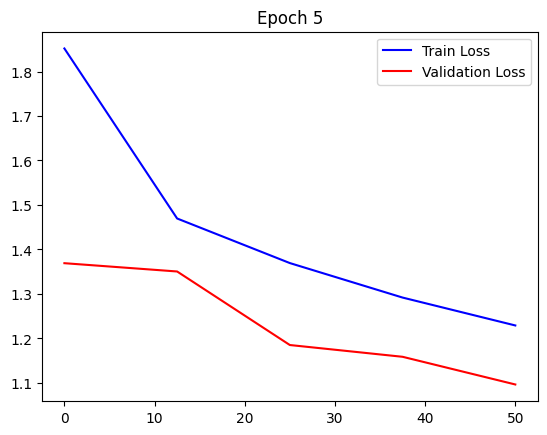

1m 50s (- 13m 29s) (6 12%) /// Train Loss: 1.1981 - Validation Loss: 1.1037
2m 8s (- 13m 10s) (7 14%) /// Train Loss: 1.1948 - Validation Loss: 1.0974
2m 27s (- 12m 55s) (8 16%) /// Train Loss: 1.1501 - Validation Loss: 1.1038
2m 45s (- 12m 35s) (9 18%) /// Train Loss: 1.1554 - Validation Loss: 1.0974
3m 5s (- 12m 21s) (10 20%) /// Train Loss: 1.1061 - Validation Loss: 1.0373


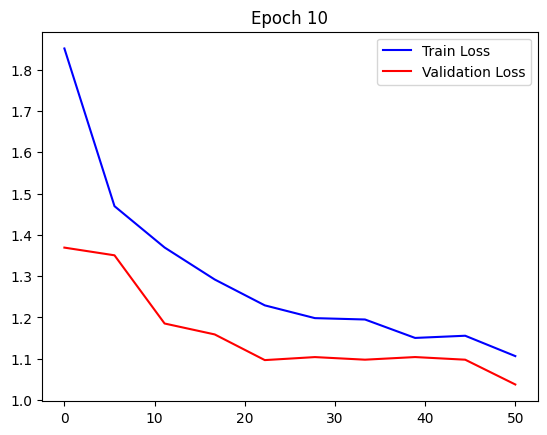

3m 26s (- 12m 12s) (11 22%) /// Train Loss: 1.0933 - Validation Loss: 1.0748
3m 46s (- 11m 55s) (12 24%) /// Train Loss: 1.0707 - Validation Loss: 1.0603
4m 5s (- 11m 39s) (13 26%) /// Train Loss: 1.0637 - Validation Loss: 1.0611
4m 37s (- 11m 54s) (14 28%) /// Train Loss: 1.0445 - Validation Loss: 1.0052
5m 11s (- 12m 6s) (15 30%) /// Train Loss: 1.0311 - Validation Loss: 1.0576


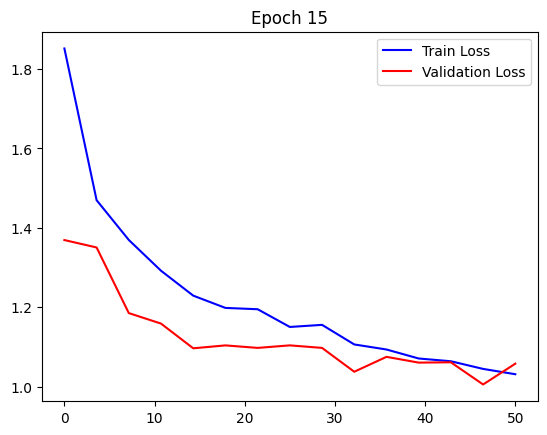

5m 31s (- 11m 44s) (16 32%) /// Train Loss: 1.0210 - Validation Loss: 1.0009
5m 51s (- 11m 21s) (17 34%) /// Train Loss: 1.0209 - Validation Loss: 0.9947
6m 25s (- 11m 25s) (18 36%) /// Train Loss: 1.0123 - Validation Loss: 1.0257
7m 4s (- 11m 32s) (19 38%) /// Train Loss: 0.9918 - Validation Loss: 1.0439
7m 51s (- 11m 47s) (20 40%) /// Train Loss: 0.9979 - Validation Loss: 1.0240


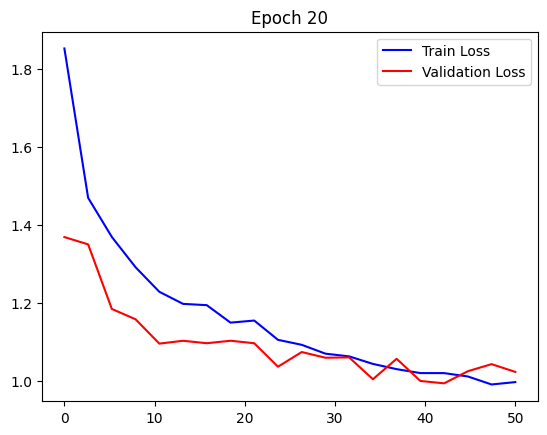

8m 53s (- 12m 17s) (21 42%) /// Train Loss: 0.9849 - Validation Loss: 1.0359
9m 57s (- 12m 39s) (22 44%) /// Train Loss: 0.9897 - Validation Loss: 1.0741
EARLY STOPPING !!!


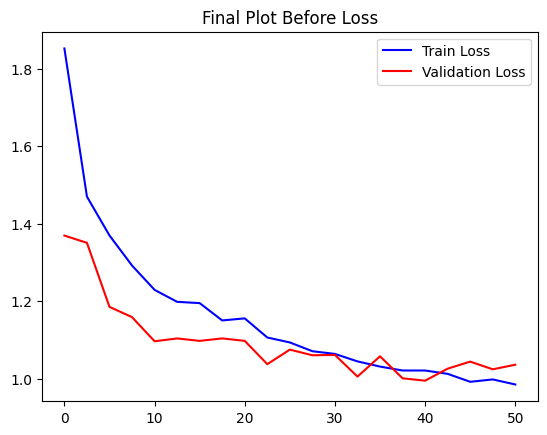

In [102]:
train(train_loader,val_loader, test_loader, encoder, decoder,
      num_epoch=NUM_EPOCHS,
      learning_rate=LEARNING_RATE,
      tf_rate = TEACHER_FORCING_RATE,
      )

In [103]:
criterion = nn.L1Loss()
test_loss = 0
for input, target, _ in test_loader :
    prediction, _, _ = evaluate(input, encoder, decoder, smi_dic, longest_smi)
    loss = criterion(prediction, target)
    test_loss += loss.item()

print(test_loss / len(test_loader))

1.2198052576610021


C:\Users\DELL\AppData\Local\Temp\ipykernel_3984\1068443758.py:207: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([''] + list(smi), fontsize="xx-large")
C:\Users\DELL\AppData\Local\Temp\ipykernel_3984\1068443758.py:208: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels([''] + list(smi), fontsize='xx-large')


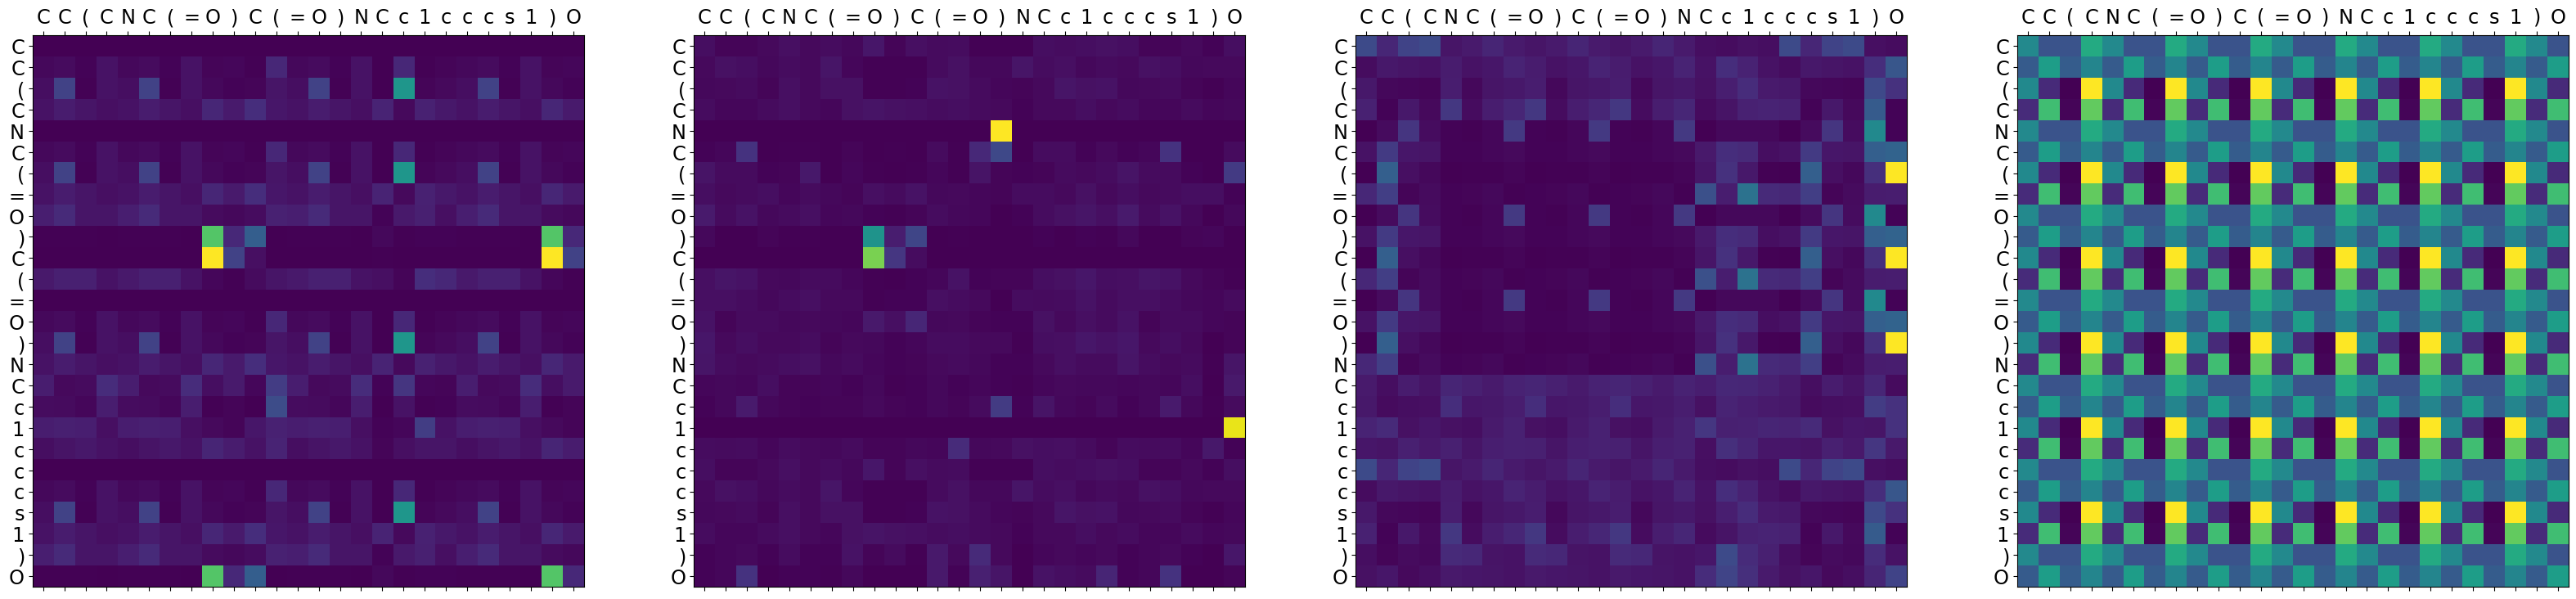

C:\Users\DELL\AppData\Local\Temp\ipykernel_3984\1068443758.py:195: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(smi))


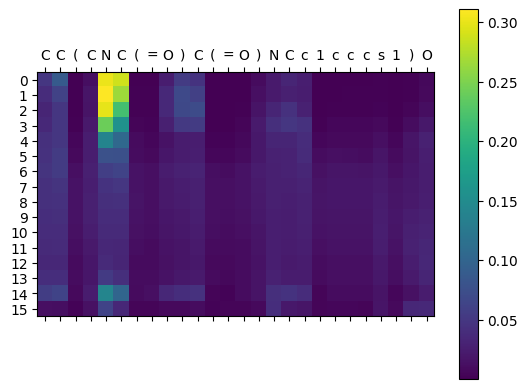

([tensor([-0.1200,  0.0200, -0.0300]),
  tensor([-1.2200, -0.1800, -0.1100]),
  tensor([-2.4300, -0.4900, -0.2200]),
  tensor([-3.6200, -0.4900, -0.2900]),
  tensor([-4.5900, -0.6600, -0.3300]),
  tensor([-5.4900, -0.6500, -0.3200]),
  tensor([-6.3400, -0.6100, -0.3000]),
  tensor([-7.1100, -0.6200, -0.2300]),
  tensor([-8.1200, -0.6300, -0.2700]),
  tensor([-9.2600, -0.5400, -0.3200]),
  tensor([-10.4200,  -0.4400,  -0.3000]),
  tensor([-11.3900,  -0.3300,  -0.2700]),
  tensor([-11.7400,  -0.2600,  -0.2500]),
  tensor([-11.4900,  -0.3200,  -0.1900]),
  tensor([-11.2200,  -0.4300,  -0.2200]),
  tensor([-0.4700, -0.1100, -0.0200]),
  tensor([0.0500, 0.0100, 0.0100]),
  tensor([0.0100, 0.0000, 0.0100]),
  tensor([0.0100, 0.0000, 0.0100]),
  tensor([0.0200, 0.0000, 0.0100]),
  tensor([0.0200, 0.0100, 0.0100]),
  tensor([0.0300, 0.0100, 0.0100])],
 tensor([[  0.0000,   0.0000,   0.0000],
         [ -1.1500,  -1.0000,   0.0700],
         [ -2.4700,  -0.2800,  -0.2000],
         [ -3.5900,  

In [109]:
r = random.randint(0, len(smi_list))

visualize(smi_list[r], encoder, decoder, smi_dic, longest_smi, output_path=ATTENTION_IMAGE_OUTPUT_PATH, output_name=f"test")
prediction, _, _ = evaluate(smi_list[r], encoder, decoder, smi_dic, longest_smi)
prediction = [torch.round(i, decimals=2) for i in prediction]
prediction, np_coor_list[r]

In [92]:
10 ** a

tensor([[ 3.4703, 10.4494,  7.2027],
        [ 0.8453,  0.4752, 12.4664]])